# EDA

## Libraries

In [1]:
import straw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm, Normalize
import seaborn as sns
import sklearn 
import networkx as nx
import igraph as ig
from itertools import count

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Kod z https://stackoverflow.com/a/49199019 generujący zawartość requirements.txt
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
            
        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
            
        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

print('hic-straw==0.0.6')
for i in range(len(requirements)):
    print(f'{requirements[i][0]}=={requirements[i][1]}')

hic-straw==0.0.6
matplotlib==3.5.1
networkx==3.1
numpy==1.22.4
pandas==1.4.2
scikit-learn==1.0.2
igraph==0.11.4
seaborn==0.11.2


## Data load and preperation

In [2]:
def get_df(normalisation, file_path, chromosome_1, chromosome_2, length_unit, resolution):
    # Data from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE63525
    # GSE63525_GM12878_diploid_maternal.hic
    df = straw.straw(normalisation, file_path, chromosome_1, chromosome_2, length_unit, resolution) 
    # example values: "KR", "../Data/GSE63525_GM12878_diploid_maternal.hic", "11", "11", "BP", 500000

    # Transforming the list to a data frame with three columns.
    # Origininally the raed data is a list of three lists, 
    # each with the same length (list of x, y and counts).
    df = pd.DataFrame(df).transpose()
    df.columns = ['x', 'y', 'count']

    # Remove interactions with itself (don't know if I should remove, but makes graph look better)
    df.loc[df['x'] == df['y'], 'count'] = 0

    return df
    
    
    
def general_information_about_df(df):
    print(f'Number of rows: {len(df)}')
    print(f"Number of unique x and y values: {df['x'].nunique()}, {df['y'].nunique()}")
    print(f"Mean interactions per fragment {df['count'].mean()}")
    print(f"Median of interactions per fragment {df['count'].median()}")
    
# def format_df(df):
    # Nothing to see here
    # df.loc[abs(df['x'] - df['y'])>30000000, 'count'] = 0
    # df.loc[df['count']<df_mean, 'count'] = 0
    # df.loc[df['count']<df_median, 'count'] = 0

In [3]:
df = get_df("KR", "../Data/GSE63525_GM12878_diploid_maternal.hic", "11", "11", "BP", 500000)
general_information_about_df(df)

HiC version:  7
Number of rows: 35209
Number of unique x and y values: 265, 265
Mean interactions per fragment 121.3970310300261
Median of interactions per fragment 43.80922173608237


## Making a contact matrix

In [5]:
def create_contact_matrix(df, save=False, resolution=None, save_path=None):
    # Changing form from long to short to use as a matrix in plots
    df_wide = df.pivot(index='x', columns='y', values='count')
    
    # # Contact matrix with matplotlib (in-notebook preview doesn't work for larger data sizes)
    # plt.imshow(df_wide, cmap='autumn', vmin=0)
    # plt.gca().invert_yaxis()
    # plt.legend().set_visible(False)
    # plt.gca().axes.get_xaxis().set_visible(False)
    # plt.gca().axes.get_yaxis().set_visible(False)
    # plt.gca().set_aspect('equal', adjustable='box')
    # # plt.savefig('test.png', dpi=2500)
    # plt.show()
    
    # Contact matrix with seaborn (better)
    sns.set_theme(rc={'figure.figsize':(8, 8)})
    sns.heatmap(df_wide, cbar=False, vmin=0, square=True, norm=LogNorm())
    plt.gca().invert_yaxis()
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    if save:  
        plt.savefig(f'{save_path}', dpi=resolution)
    plt.show()

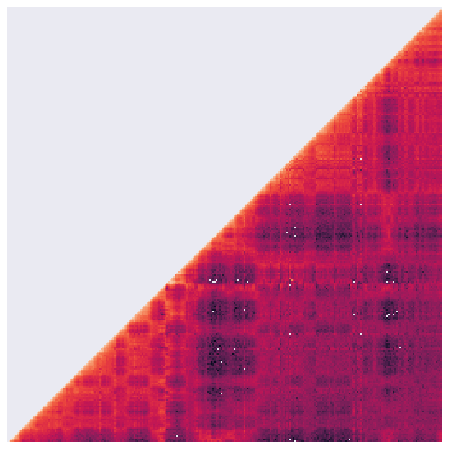

In [6]:
create_contact_matrix(df, False, 500, './ContactMatrixResults/test0.png')

## Making a graph

In [5]:
def create_graph_v1(df):
    # Creatinga en edgelist from dataframe
    edges = pd.DataFrame({'source': df['x'],
                          'target': df['y'],
                          'weight': df['count']})

    # Creating a graph from edgelist
    G = nx.from_pandas_edgelist(edges, 'source', 'target', 'weight')
    
    return G



def draw_graph_v1(G, save=False, resolution=None, save_path=None):
    # Canvas
    fig, ax = plt.subplots(1, 1, figsize=(16, 16))
    
    # Nodes' poistion
    position = nx.drawing.layout.spring_layout(G)
    nx.set_node_attributes(G, position, 'pos')

    node_colors = range(len(G.nodes()))

    # Drawing the graph
    nx.draw(G,
            pos = position,
            node_size = 40,
            width = [e[2]["weight"] * 0.0001 for e in G.edges(data=True)],
            node_color=node_colors,
            ax = ax
           )

    # Nodes' labels
    for i, (node, (x, y)) in enumerate(position.items()):
        ax.text(x, y, i, fontsize = 10, ha = "center", va = "center")

    # Saving the graph
    if save:  
        plt.savefig(f'{save_path}', dpi=resolution)
    plt.show()
    
    
    
def draw_igraph_from_networkx_grapf_v1(G, save=False, resolution=None, save_path=None):
    h = ig.Graph.from_networkx(G)

    layout = []
    for key in position.keys():
        layout.append(position.get(key))

    fig, ax = plt.subplots(1, 1, figsize=(16, 16))

    ig.plot(h, layout=layout, target=ax)
    plt.axis("off")
    
    # Saving the graph
    if save:  
        plt.savefig(f'{save_path}', dpi=resolution)
    plt.show()
    
def get_information_about_graph(G):
    df_with_info = None
    return df_with_info

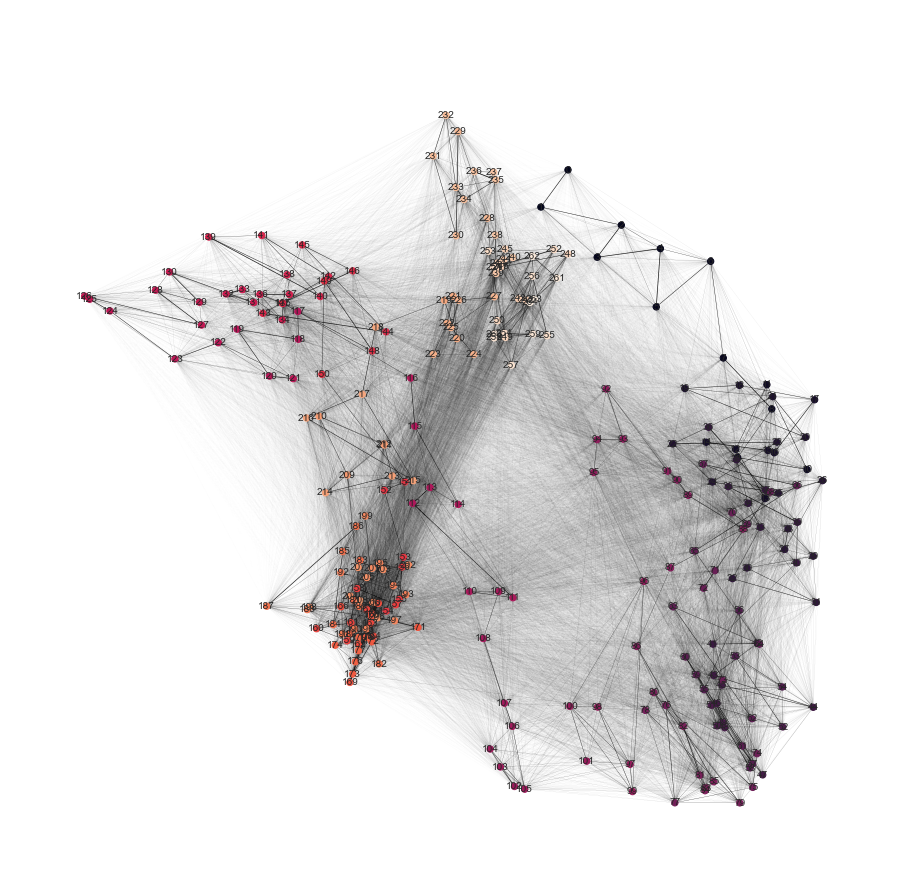

In [8]:
G = create_graph_v1(df)
draw_graph_v1(G, False, 500, './NetworkxGraphResults/test0.png')

## Chromosome analysis

In [9]:
chromosome_information_df=pd.DataFrame({
    "Chromosome": [],
    "Number_of_rows": [],
    "Number_of_fragments": [],
    "Mean_interactions": [],
    "Median_interactions": [],
    "Variance": []
})
resolution = 1000000
for i in range(1, 23):
    tmp_df = get_df("KR", "../Data/GSE63525_GM12878_diploid_maternal.hic", f"{i}", f"{i}", "BP", resolution)
    number_of_rows=len(tmp_df)
    unique_fragments=tmp_df['x'].nunique()
    mean=tmp_df['count'].mean()
    median=tmp_df['count'].median()
    variance=tmp_df['count'].var()
    chromosome_information_df.loc[i] = [f"{i}", number_of_rows, unique_fragments, mean, median, variance]
tmp_df = get_df("KR", "../Data/GSE63525_GM12878_diploid_maternal.hic", "X", "X", "BP", resolution)
number_of_rows=len(tmp_df)
unique_fragments=tmp_df['x'].nunique()
mean=tmp_df['count'].mean()
median=tmp_df['count'].median()
variance=tmp_df['count'].var()
chromosome_information_df.loc[23] = ['X', number_of_rows, unique_fragments, mean, median, variance]
# This data abviously doesn't have the Y chromosome
# tmp_df = get_df("KR", "../Data/GSE63525_GM12878_diploid_maternal.hic", "Y", "Y", "BP", resolution)
# number_of_rows=len(tmp_df)
# unique_fragments=tmp_df['x'].nunique()
# mean=tmp_df['count'].mean()
# median=tmp_df['count'].median()
# variance=tmp_df['count'].var()
# chromosome_information_df.loc[24] = ['Y', number_of_rows, unique_fragments, mean, median, variance]
# chromosome_information_df.head(24)

HiC version:  7
HiC version:  7
HiC version:  7
HiC version:  7
HiC version:  7
HiC version:  7
HiC version:  7
HiC version:  7
HiC version:  7
HiC version:  7
HiC version:  7
HiC version:  7
HiC version:  7
HiC version:  7
HiC version:  7
HiC version:  7
HiC version:  7
HiC version:  7
HiC version:  7
HiC version:  7
HiC version:  7
HiC version:  7
HiC version:  7


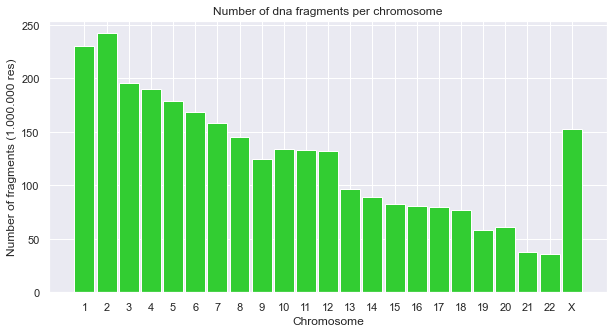

In [10]:
fig = plt.figure(figsize = (10, 5))

plt.bar(x=chromosome_information_df['Chromosome'],
        height=chromosome_information_df['Number_of_fragments'],
        color ='limegreen', width = 0.9)
plt.gca().set_xticks(chromosome_information_df['Chromosome'])
plt.xlabel("Chromosome")
plt.ylabel("Number of fragments (1.000.000 res)")
plt.title("Number of dna fragments per chromosome")
plt.show()

## Testing different data formats

#### NONE, X, X, BP, 500.000

HiC version:  7
Number of rows: 46299
Number of unique x and y values: 305, 301
Mean interactions per fragment 60.30849478390462
Median of interactions per fragment 21.0


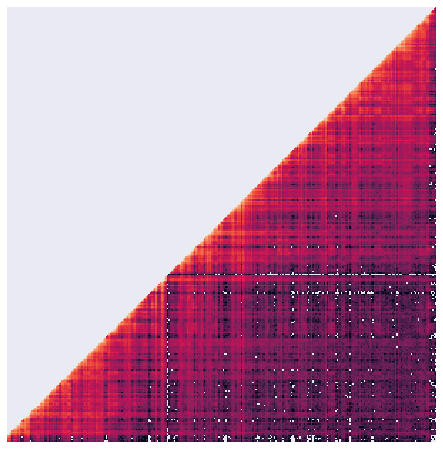

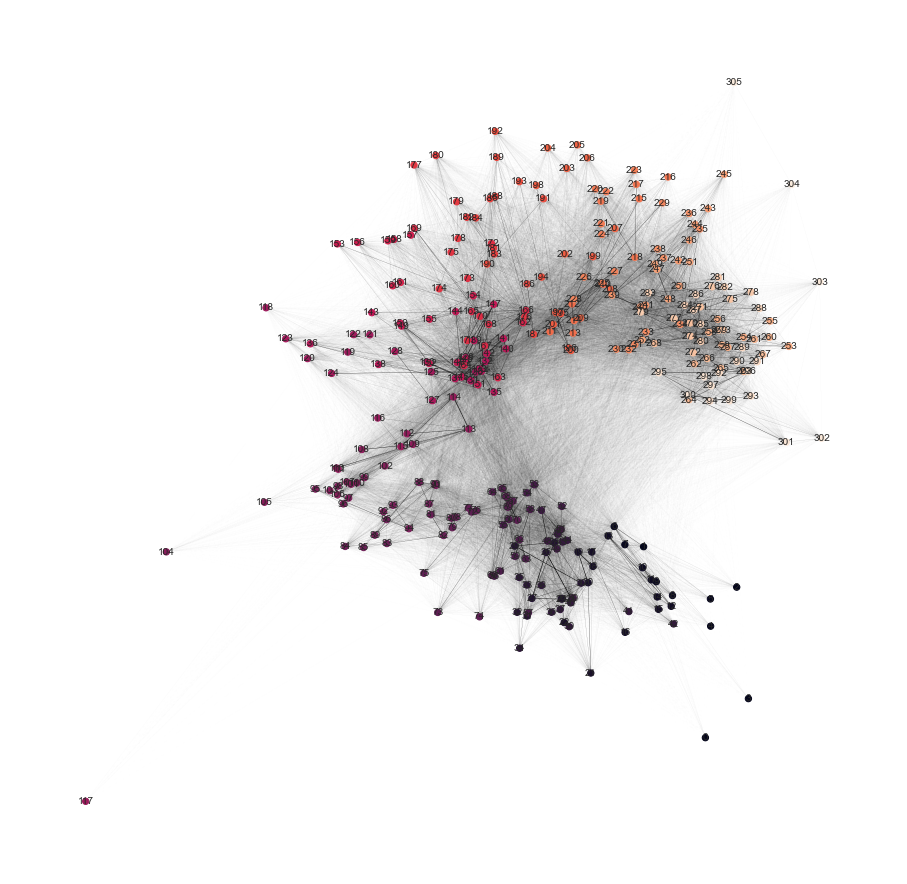

In [11]:
df = get_df("NONE", "../Data/GSE63525_GM12878_diploid_maternal.hic", "X", "X", "BP", 500000)
general_information_about_df(df)
create_contact_matrix(df, False, 1000, './ContactMatrixResults/matrix_NONE_X_X_BP_500_000.png')
G = create_graph_v1(df)
draw_graph_v1(G, False, 1000, './NetworkxGraphResults/graph_NONE_X_X_BP_500_000.png')
get_information_about_graph(G)

#### KR, X, X, BP, 1.000.000

HiC version:  7
Number of rows: 11918
Number of unique x and y values: 153, 152
Mean interactions per fragment 220.19749772283112
Median of interactions per fragment 97.63276065591154


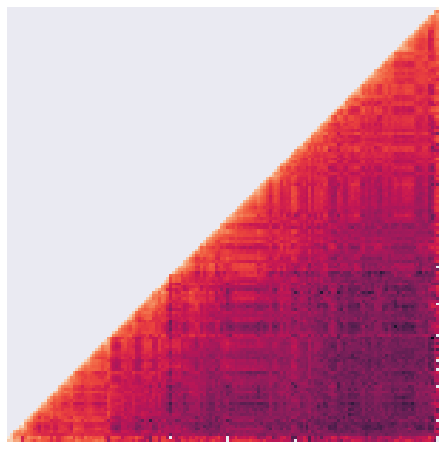

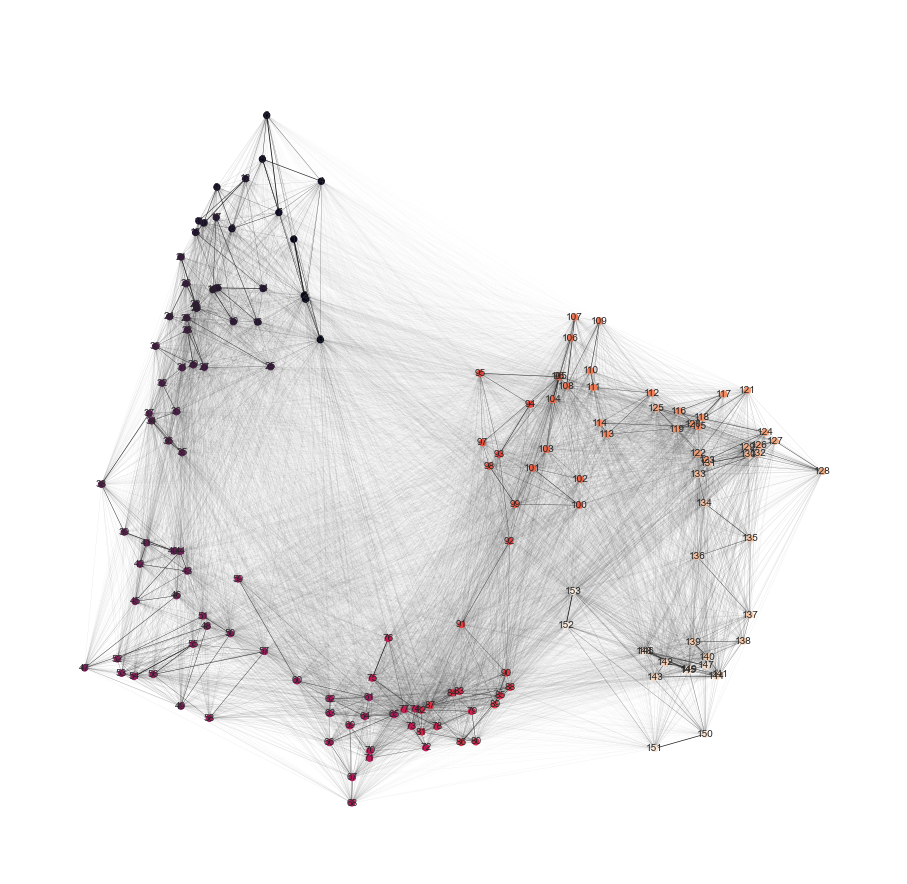

In [14]:
df = get_df("KR", "../Data/GSE63525_GM12878_diploid_maternal.hic", "X", "X", "BP", 1000000)
general_information_about_df(df)
create_contact_matrix(df, False, 1000, './ContactMatrixResults/matrix_KR_X_X_BP_1_000_000.png')
G = create_graph_v1(df)
draw_graph_v1(G, False, 1000, './NetworkxGraphResults/graph_KR_X_X_BP_1_000_000.png')
get_information_about_graph(G)

#### KR, X, X, BP, 500.000

HiC version:  7
Number of rows: 46299
Number of unique x and y values: 305, 301
Mean interactions per fragment 63.79889464598166
Median of interactions per fragment 25.843551150958184


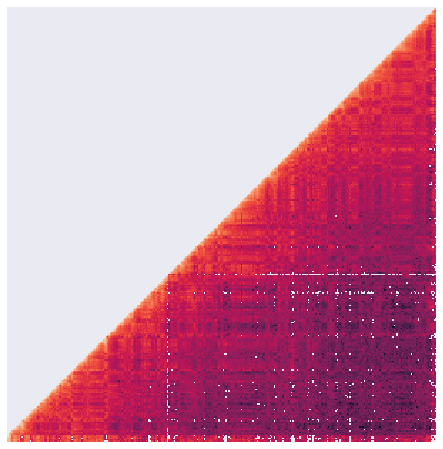

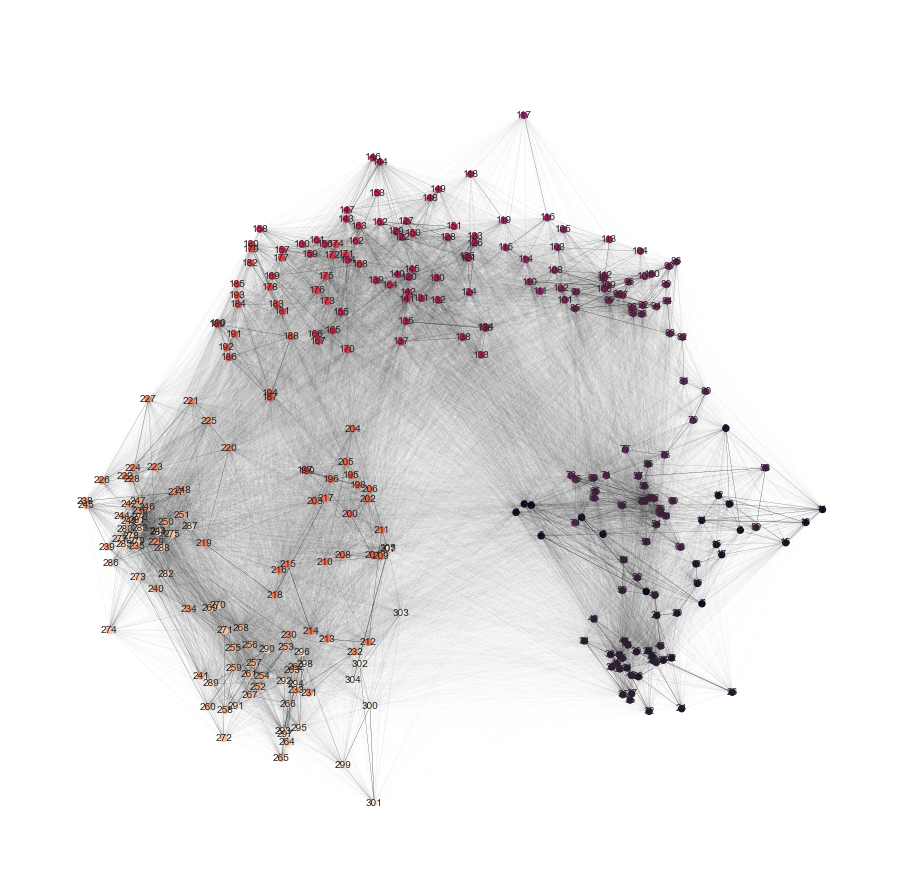

In [15]:
df = get_df("KR", "../Data/GSE63525_GM12878_diploid_maternal.hic", "X", "X", "BP", 500000)
general_information_about_df(df)
create_contact_matrix(df, False, 1000, './ContactMatrixResults/matrix_KR_X_X_BP_500_000.png')
G = create_graph_v1(df)
draw_graph_v1(G, False, 1000, './NetworkxGraphResults/graph_KR_X_X_BP_500_000.png')
get_information_about_graph(G)

#### KR, X, X, BP, 250.000

HiC version:  7
Number of rows: 166049
Number of unique x and y values: 608, 600
Mean interactions per fragment 19.438023679283233
Median of interactions per fragment 7.517558508578431


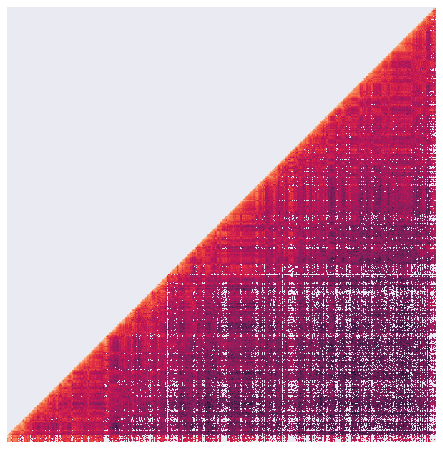

StopIteration: 

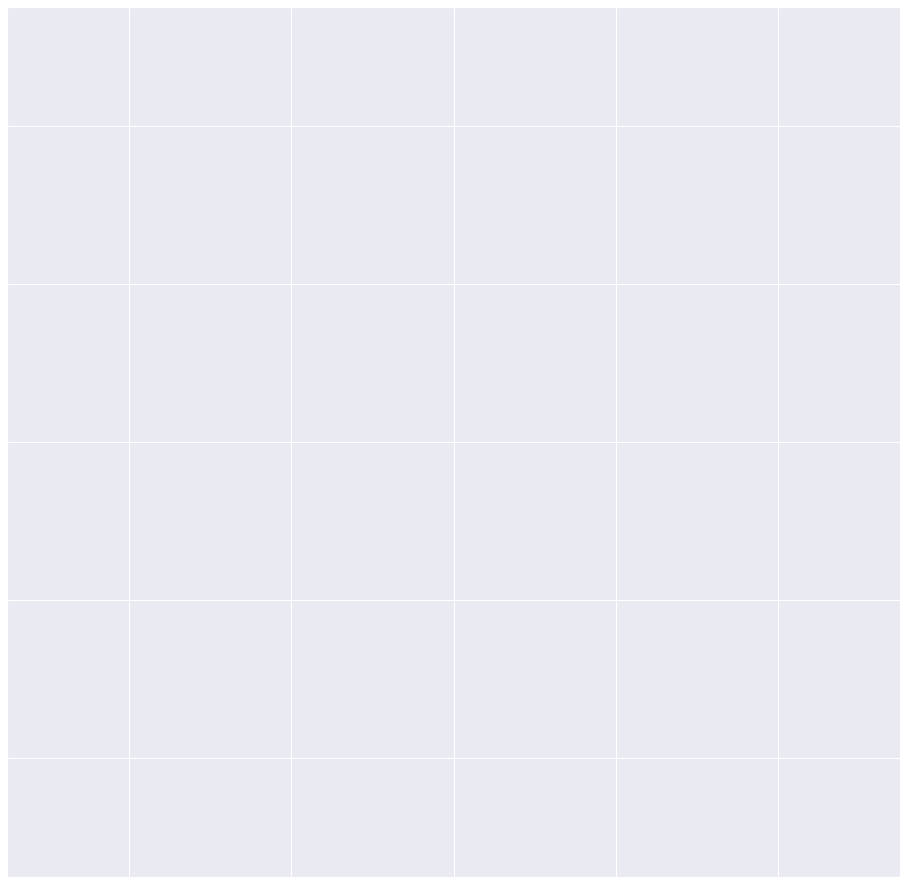

In [16]:
df = get_df("KR", "../Data/GSE63525_GM12878_diploid_maternal.hic", "X", "X", "BP", 250000)
general_information_about_df(df)
create_contact_matrix(df, False, 1000, './ContactMatrixResults/matrix_NONE_X_X_BP_250_000.png')
G = create_graph_v1(df)
draw_graph_v1(G, False, 1000, './NetworkxGraphResults/graph_NONE_X_X_BP_250_000.png')
get_information_about_graph(G)

#### KR, 11, 11, BP, 500.000

HiC version:  7
Number of rows: 35209
Number of unique x and y values: 265, 265
Mean interactions per fragment 121.3970310300261
Median of interactions per fragment 43.80922173608237


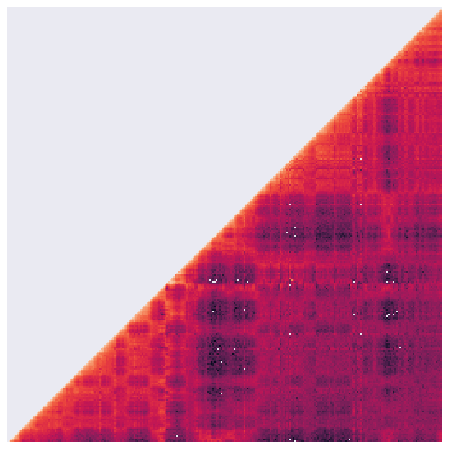

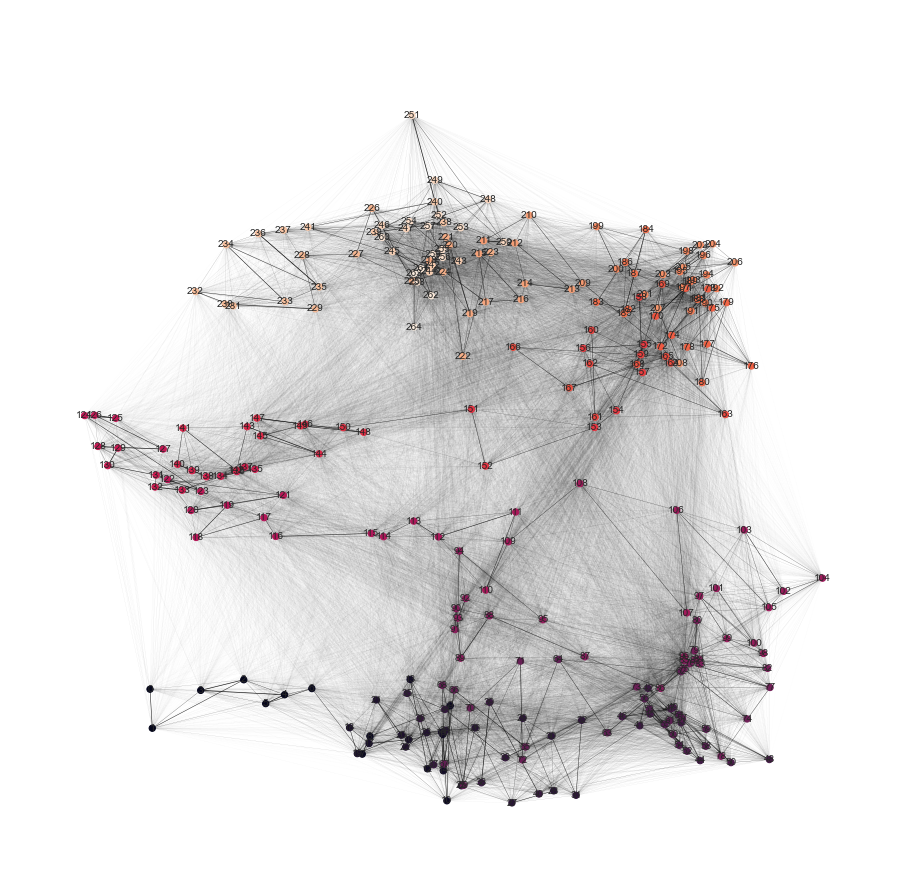

In [17]:
df = get_df("KR", "../Data/GSE63525_GM12878_diploid_maternal.hic", "11", "11", "BP", 500000)
general_information_about_df(df)
create_contact_matrix(df, False, 1000, './ContactMatrixResults/matrix_KR_11_11_BP_500_000.png')
G = create_graph_v1(df)
draw_graph_v1(G, False, 1000, './NetworkxGraphResults/graph_KR_11_11_BP_500_000.png')
get_information_about_graph(G)

#### KR, 4, 8, BP, 1.000.000

HiC version:  7
Number of rows: 27332
Number of unique x and y values: 190, 145
Mean interactions per fragment 18.422173288667757
Median of interactions per fragment 17.675660806035747


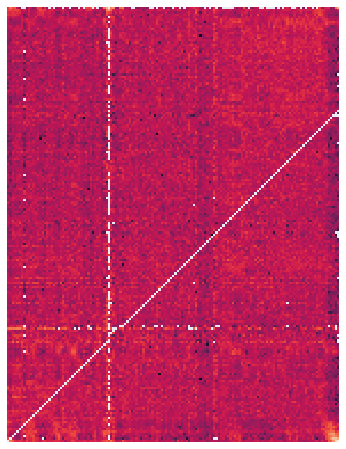

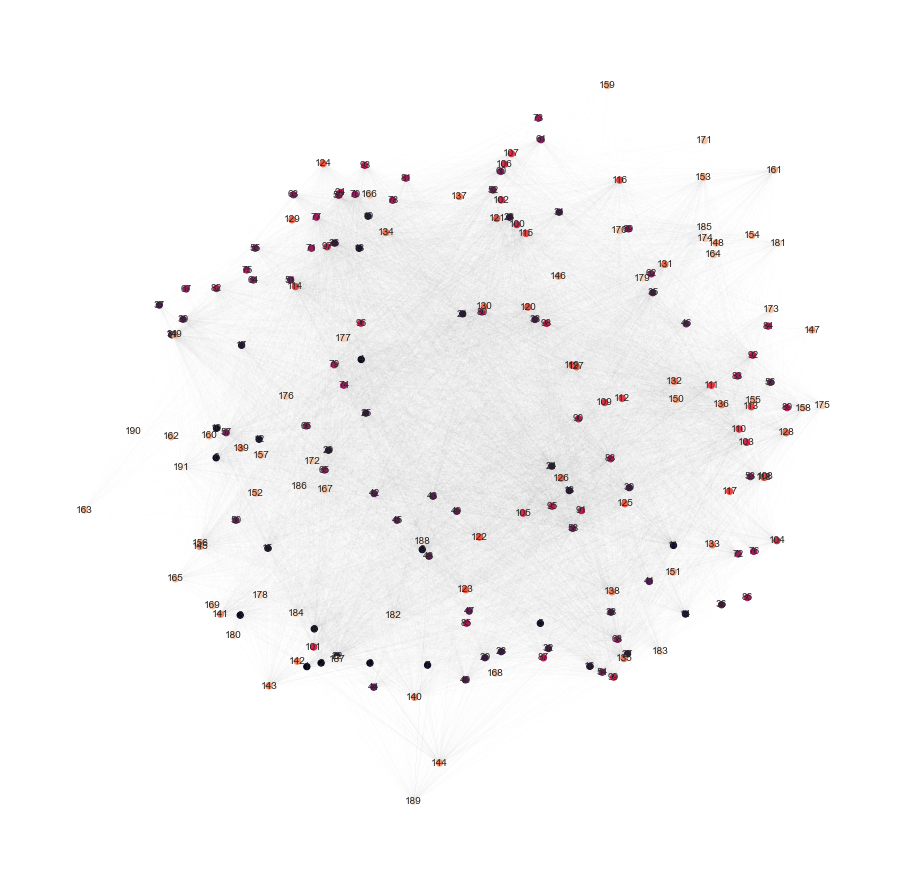

In [18]:
df = get_df("KR", "../Data/GSE63525_GM12878_diploid_maternal.hic", "4", "8", "BP", 1000000)
general_information_about_df(df)
create_contact_matrix(df, False, 1000, './ContactMatrixResults/matrix_KR_4_8_BP_1_000_000.png')
G = create_graph_v1(df)
draw_graph_v1(G, False, 1000, './NetworkxGraphResults/graph_KR_4_8_BP_1_000_000.png')
get_information_about_graph(G)

#### KR, 1, 1, BP, 250.000

HiC version:  7
Number of rows: 371859
Number of unique x and y values: 913, 912
Mean interactions per fragment 22.170244773520796
Median of interactions per fragment 6.445855178364385


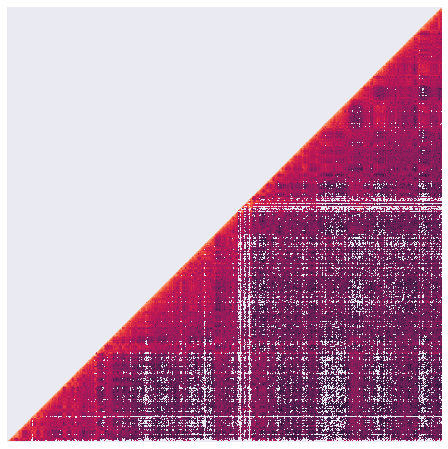

StopIteration: 

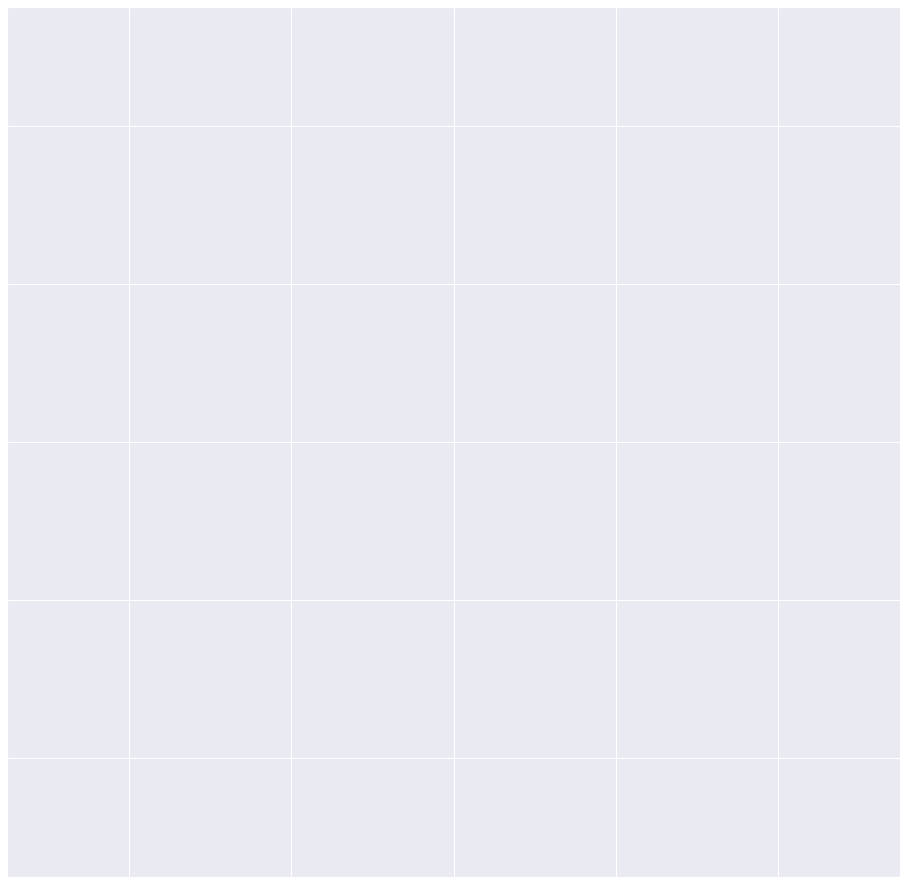

In [19]:
df = get_df("KR", "../Data/GSE63525_GM12878_diploid_maternal.hic", "1", "1", "BP", 250000)
general_information_about_df(df)
create_contact_matrix(df, False, 1000, './ContactMatrixResults/matrix_KR_4_8_BP_1_000_000.png')
G = create_graph_v1(df)
draw_graph_v1(G, False, 1000, './NetworkxGraphResults/graph_KR_4_8_BP_1_000_000.png')
get_information_about_graph(G)

## Graph analysis

HiC version:  7
Number of rows: 46299
Number of unique x and y values: 305, 301
Mean interactions per fragment 63.79889464598166
Median of interactions per fragment 25.843551150958184


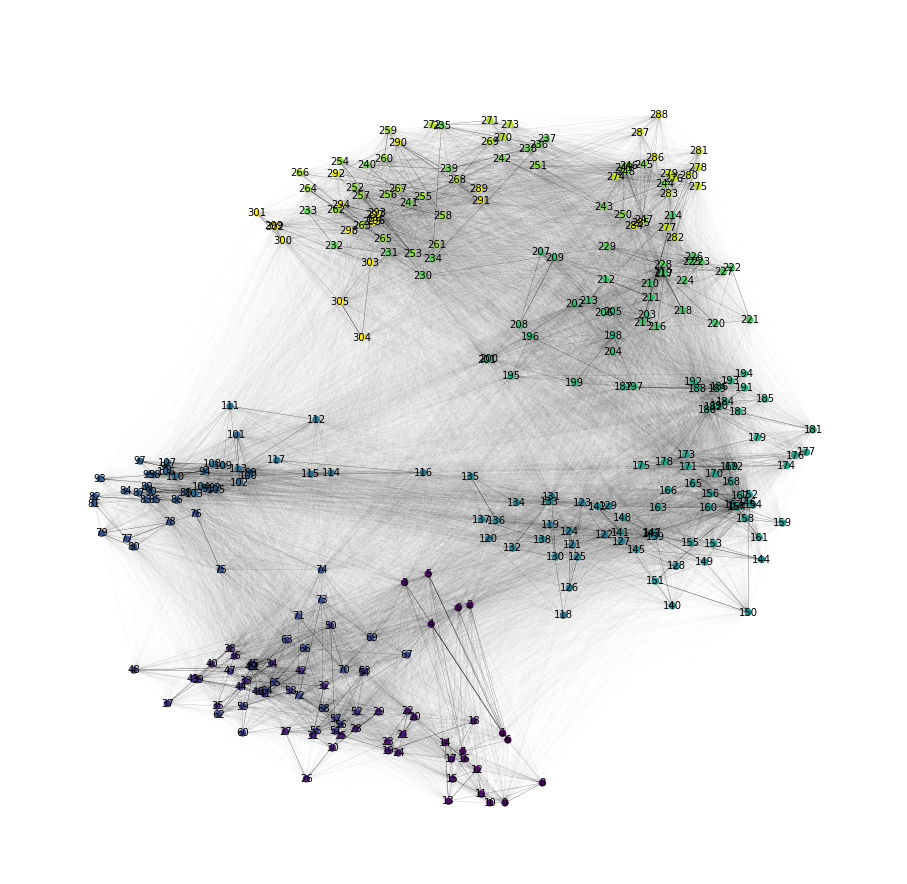

In [80]:
df = get_df("KR", "../Data/GSE63525_GM12878_diploid_maternal.hic", "X", "X", "BP", 500000)
general_information_about_df(df)
G = create_graph_v1(df)
draw_graph_v1(G, False, 500, './NetworkxGraphResults/test0.png')

In [116]:
graph_information_df=pd.DataFrame({
    "Node_order": [],
    "Node_number": [],
    "Degree": [],
    "Incident_edges_weight": [],
    "Average_weight_per_edge": [],
    "Neighbouring_nodes_edges_wieghts": [],
    "Betweenness_centrality": []
})
btw=nx.betweenness_centrality(G, normalized=False)
i=1
for item in G.nodes():
    incident_edges=len(G.edges(item, data=True))
    sum_of_weights=0
    sum_of_neighbours_weights=0
    for edge in G.edges(item, data=True):
        sum_of_weights+=edge[2]['weight']
        neighbour_node = edge[1]
        for edge2 in G.edges(neighbour_node, data=True):
            sum_of_neighbours_weights+=edge2[2]['weight']
    betweenness_centrality=btw.get(item)
    graph_information_df.loc[i] = [f"{i}", item, incident_edges, sum_of_weights, sum_of_weights/incident_edges,
                                   sum_of_neighbours_weights, betweenness_centrality]
    i+=1
graph_information_df.head()

Node_order  Node_number  Degree  Incident_edges_weight  \
1          1          0.0     268           24755.054740   
2          2    2500000.0     305           20511.387697   
3          3     500000.0     279           24755.052245   
4          4    1000000.0     256           24755.053506   
5          5    1500000.0     274           24755.049160   

   Average_weight_per_edge  Neighbouring_nodes_edges_wieghts  \
1                92.369607                      5.121728e+06   
2                67.250451                      5.896363e+06   
3                88.727786                      5.340766e+06   
4                96.699428                      4.895000e+06   
5                90.346895                      5.247184e+06   

   Betweenness_centrality  
1                0.307361  
2                1.942747  
3                0.599807  
4                0.296627  
5                0.400172

In [117]:
graph_information_df.describe()

Node_number      Degree  Incident_edges_weight  \
count  3.060000e+02  306.000000             306.000000   
mean   7.778595e+07  301.627451           19306.045903   
std    4.527172e+07   10.665331            1438.710907   
min    0.000000e+00  166.000000           11286.593776   
25%    3.812500e+07  302.000000           18622.419346   
50%    7.875000e+07  305.000000           19243.301016   
75%    1.168750e+08  306.000000           19833.680522   
max    1.550000e+08  306.000000           24755.054740   

       Average_weight_per_edge  Neighbouring_nodes_edges_wieghts  \
count               306.000000                      3.060000e+02   
mean                 64.111966                      5.821898e+06   
std                   5.800212                      2.119139e+05   
min                  48.632256                      3.202813e+06   
25%                  61.373610                      5.826497e+06   
50%                  63.215291                      5.890420e+06   
75%                  65.278616                      5.907650e+06   
max                  96.699428                      5.907650e+06   

       Betweenness_centrality  
count              306.000000  
mean                 2.176471  
std                  0.620970  
min                  0.208897  
25%                  1.777495  
50%                  2.008028  
75%                  2.801329  
max                  2.801329

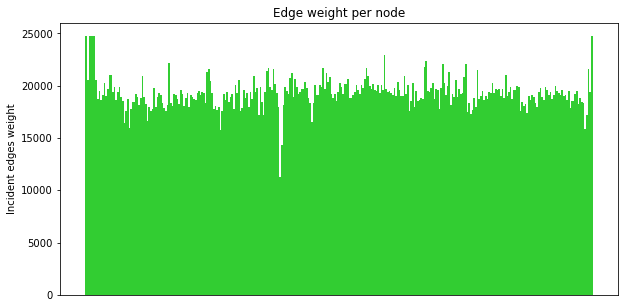

In [82]:
fig = plt.figure(figsize = (10, 5))

plt.bar(x=graph_information_df['Node_order'],
        height=graph_information_df['Incident_edges_weight'],
        color ='limegreen', width = 1)
plt.gca().axes.get_xaxis().set_visible(False)
plt.xlabel("Node")
plt.ylabel("Incident edges weight")
plt.title("Edge weight per node")
plt.show()

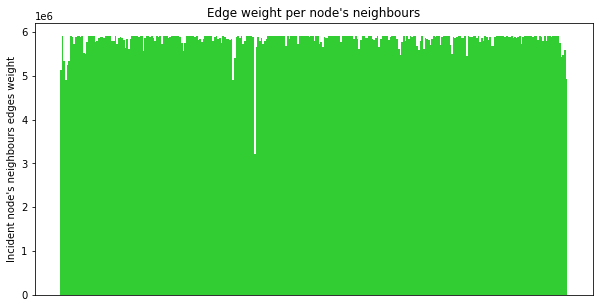

In [91]:
fig = plt.figure(figsize = (10, 5))

plt.bar(x=graph_information_df['Node_order'],
        height=graph_information_df['Neighbouring_nodes_edges_wieghts'],
        color ='limegreen', width = 1)
plt.gca().axes.get_xaxis().set_visible(False)
plt.xlabel("Node")
plt.ylabel("Incident node's neighbours edges weight")
plt.title("Edge weight per node's neighbours")
plt.show()

## Comparison with other methods of obtaining interaction data
...

## Conslusion
- higher resolution leads to more null obserwations, but lowe resolutions contain less information
- there is no point in analysing interactions in two different chromosomes as TADs are interchromosomal structures'
- chromosome fragment count increases with chromosome ordinal number, which is to be expected and is a testament to the credibility of the used data
- using spirng layout in networkx already yelds visible clusters witch represent visible TADs in the corresponding heatmaps
- judging purely on visual basis based on the matrices, KR is the best normalization method
- networkx quickly reaches maximum number of itertions and 500.000 resolution is most likely the only feasible resollution which compromises performance, data quality and package's restrictions
- deleting some edges (a certain distance from two fragments) which certinally can't be in the same TAD leads to worse visual representation of clusters in graphs, which means all edges should be included (this was tested using commented-out code in df_format function. The resulting graph's nodes were all following a single curve with clusters failling to retain their previous boundries.)
- nodes are connected with other nodes outside their TADs just as much as with any other nodes, only weights differ
- all nodes seem to have similar count of weights of incident edges, as well as the sum of weights of edges incident with neighbouring nodes